# Reading vertextree

In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np

Opening vertex tree, getting tree and branches

In [2]:
vtxfile = uproot.open("/eos/user/a/aiulian/sim_fedra/SNDnuyield_30_September_2021/b000022/vertextree.root")
vtxtree = vtxfile["vtx"]

In [3]:
vtxinfo = vtxtree.arrays(["n","t.eFlag","MCEventID","MCTrackID","MCMotherID","vx","vy","vz","vID","incoming"])
vtxinfo["MCTrackPdgCode"] = vtxinfo["t.eFlag"]

## Topology selection

First, we ask ourselves: how many daughters? I.e. How many tracks with incoming 1?

In [4]:
ndaughters = []
for ntracks, incoming in zip(vtxinfo["n"],vtxinfo["incoming"]):
    nd = 0
    for itrk in range(ntracks):
        if(incoming[itrk]==1):
            nd = nd + 1
    ndaughters.append(nd)
vtxinfo["ndaughters"] = ndaughters

Text(0.5, 1.0, 'Number of tracks associated to the vertex')

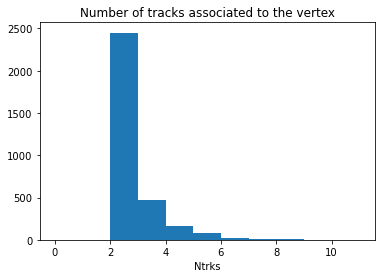

In [5]:
plt.hist(vtxinfo["n"],bins=11,range=[0,11])
plt.xlabel("Ntrks")
plt.title("Number of tracks associated to the vertex")

Text(0.5, 1.0, 'Number of tracks coming FROM the vertex')

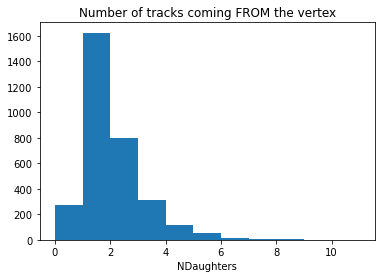

In [6]:
plt.hist(vtxinfo["ndaughters"],bins=11,range=[0,11])
plt.xlabel("NDaughters")
plt.title("Number of tracks coming FROM the vertex")

We **select only vertices with at least 2 daughters**
That means we exclude topologies 0-0, 0-1, 0-0-1, etc., with only one track coming from the vertex (i.e. 0prong and 1 prong vertices)

In [7]:
nvertices = len(vtxinfo)
vtxinfo = vtxinfo[vtxinfo["ndaughters"]>=2]
nvertices2dau = len(vtxinfo)
print("{} vertices out of {} with at least 2 daughters".format(nvertices2dau,nvertices))

1300 vertices out of 3201 with at least 2 daughters


We want to check how many vertices are good vertices. I.e. have same mother

In [8]:
def correctvertex(vtxinfo):
    '''vertex tracks have same MC mother'''
    #start loop over vertices
    samemother = []

    for (ntracks, motherids, incoming) in zip(vtxinfo["n"], vtxinfo["MCMotherID"], vtxinfo["incoming"]):
        goodvertex = True
        ndaughters = 0
        #loop over tracks, comparing mothers
        for itrk in range(ntracks):
            if (incoming[itrk] == 1): #track coming from the vertex
                ndaughters = ndaughters + 1
            for jtrk in range(itrk):
             if (motherids[jtrk] != motherids[itrk] and incoming[jtrk] == incoming[itrk]): #same direction, but different mother
                goodvertex = False
        #end of loop, storing result
        if(ndaughters<2):
            goodvertex = False
        samemother.append(goodvertex)
    #end of loop over vertices, returning list of results
    return samemother

In [9]:
samemother = correctvertex(vtxinfo)
vtxinfo["SameMother"] = samemother
ngood = len(vtxinfo[samemother])
nall = len(vtxinfo)
print("{} out of {} vertices have same mother: fraction {}".format(ngood,nall,ngood/nall))

133 out of 1300 vertices have same mother: fraction 0.10230769230769231


In [10]:
print("listing some ids to manual checks: ")
print(vtxinfo[vtxinfo["SameMother"]]["vID"])

print("for example, let us see the first good one")
print(vtxinfo[vtxinfo["SameMother"]]["MCMotherID"][0])
print(vtxinfo[vtxinfo["SameMother"]]["MCTrackID"][0])
print(vtxinfo[vtxinfo["SameMother"]]["incoming"][0])

listing some ids to manual checks: 
[3, 7, 12, 19, 35, 37, 41, 43, ... 3159, 3163, 3167, 3168, 3186, 3187, 3192, 3196]
for example, let us see the first good one
[6876, 6876]
[6995, 6915]
[1, 1]


This tell us how many vertices are connected to the same MCMother. They however, could have different incoming...

## vertices from neutrino
Applying a selection for interesting vertices (i.e. one coming from neutrino)

In [11]:
#at least a track with mother ID 0
def neutrinodaughters(vtxinfo):
    ''' checking if there is at least one neutrino daughter in the vertex'''
    aneutrinodaughter = []
    for (ntracks, incoming, eventmothers) in zip(vtxinfo["n"],vtxinfo["incoming"],vtxinfo["MCMotherID"]):
        hasnudau = False 
        for itrk in range(ntracks):
            if(incoming[itrk] == 1 and eventmothers[itrk] == 0):
                hasnudau = True
        aneutrinodaughter.append(hasnudau)
    return aneutrinodaughter

aneutrinodaughter = neutrinodaughters(vtxinfo)
nuvertices = vtxinfo[aneutrinodaughter]

In [12]:
reconuvz = nuvertices["vz"]
reconumolt = nuvertices["n"]

Text(0.5, 0, 'z[$\\mu m$]')

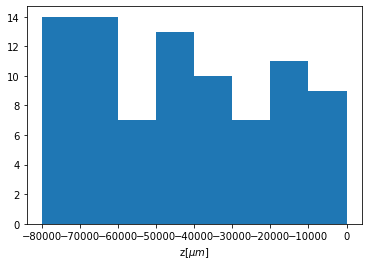

In [13]:
plt.hist(reconuvz,bins=8,range=[-80000,0])
plt.xlabel("z[$\mu m$]")

Text(0.5, 0, 'ntracks')

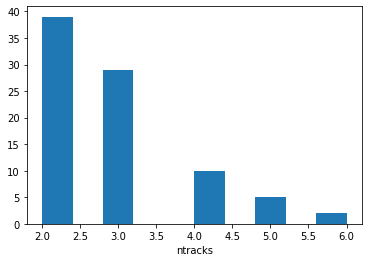

In [14]:
plt.hist(reconumolt)
plt.xlabel("ntracks")

In [15]:
import awkward

Text(0, 0.5, 'y[micron]')

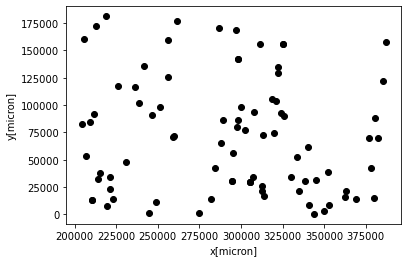

In [16]:
plt.plot(awkward.to_numpy(nuvertices["vx"]),awkward.to_numpy(nuvertices["vy"]),"ko");
plt.xlabel("x[micron]")
plt.ylabel("y[micron]")

In [17]:
nnuvertices = len(nuvertices)
nnuvertices_samemother = len(nuvertices[nuvertices["SameMother"]])

print ("{} out of {} vertices from neutrino have same mother: {}".format(nnuvertices_samemother,nnuvertices,nnuvertices_samemother/nnuvertices)) 

45 out of 85 vertices from neutrino have same mother: 0.5294117647058824


In [18]:
print("listing some ids to manual checks: ")
print(nuvertices[nuvertices["SameMother"]]["vID"])

print("for example, let us see the first good one")
print(nuvertices[nuvertices["SameMother"]]["MCMotherID"][0])
print(nuvertices[nuvertices["SameMother"]]["MCTrackID"][0])
print(nuvertices[nuvertices["SameMother"]]["MCTrackPdgCode"][0])
print(nuvertices[nuvertices["SameMother"]]["incoming"][0])

listing some ids to manual checks: 
[43, 60, 93, 99, 110, 146, 172, 185, ... 2999, 3003, 3016, 3026, 3092, 3104, 3192]
for example, let us see the first good one
[0, 0]
[2, 13]
[211, 211]
[1, 1]


## Lepton inspection

Is there a muon or an electron in these vertices?

In [19]:
nuvertices_samemother = nuvertices[nuvertices["SameMother"]]

hasmuon = []
haselectron = []

for pdgcodes in nuvertices_samemother["MCTrackPdgCode"]:
    if (np.logical_or(13 in pdgcodes,-13 in pdgcodes)):
        hasmuon.append(True)
    else:
        hasmuon.append(False)
    if (np.logical_or(11 in pdgcodes,-11 in pdgcodes)):
        haselectron.append(True)
    else:
        haselectron.append(False)


In [23]:
print("vertices with muons = {}".format(len(nuvertices_samemother[hasmuon])))
print("vertices with electrons = {}".format(len(nuvertices_samemother[haselectron])))
hasboth = np.logical_and(hasmuon,haselectron)
print("vertices with both = {}".format(len(nuvertices_samemother[hasboth])))
hasneither = np.logical_not(np.logical_or(hasmuon,haselectron))
print("vertices with neither = {}".format(len(nuvertices_samemother[hasneither])))

vertices with muons = 14
vertices with electrons = 15
vertices with both = 0
vertices with neither = 16


In [24]:
hasneither

array([ True,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True,  True,  True,
       False,  True,  True, False,  True,  True, False, False, False,
        True, False,  True, False, False, False,  True, False,  True,
       False, False, False, False, False,  True,  True, False, False])

In [26]:
nuvertices_samemother["MCTrackPdgCode"][1]

<Array [211, 321] type='2 * int32'>